In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from models.model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference

# I. General settings

In [112]:
# load data parameters 
countries = ['France', 'Germany', 'United Kingdom', 'Italy', 'Spain', 'Japan']
columns = ['year', 'population', 'gdp', 'energy_per_capita', 'country']

# preprocessing parameters
split_year = 2011  # trainset until split_year
test_country = "France"
nb_steps = 6
sliding_window = 2

# model parameters


# II. Load data

### Load raw data 

In [113]:
all_data = pd.read_csv("./data/World Energy Consumption.csv")
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22012 entries, 0 to 22011
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.7+ MB


### Select columns

In [114]:
data = all_data[columns]
data.describe()

,year,population,gdp,energy_per_capita
count,22012.000000,1.812300e+04,1.111300e+04,10602.000000
mean,1974.213247,1.053096e+08,3.585114e+11,25742.760033
std,35.058653,4.640460e+08,2.411179e+12,36122.506628
min,1900.000000,1.833000e+03,1.642060e+08,0.000000
25%,1946.000000,1.712404e+06,1.365898e+10,3101.076250
50%,1984.000000,6.991543e+06,4.167411e+10,13597.986000
75%,2003.000000,2.557688e+07,1.744295e+11,36847.052500
max,2022.000000,7.975105e+09,1.136302e+14,657539.188000


### Select countries

In [115]:
data = data.loc[data.country.isin(countries)]
data.dropna(inplace=True)  # drop all nan values
data.sample(5)

,year,population,gdp,energy_per_capita,country
10163,1994,125119264.0,3.898677e+12,45380.562,Japan
18387,1996,39996476.0,8.959665e+11,31666.996,Spain
10005,2001,56994992.0,1.910080e+12,36802.125,Italy
18358,1967,32814224.0,2.698650e+11,12541.579,Spain
20578,2013,64302296.0,2.293925e+12,36881.977,United Kingdom


# III. Preprocessing 

### Stationarization 

Fonction permettant de stationariser les time series:

In [116]:
def stationarize(input_df: pd.DataFrame):
    """
    Given data corresponding to only one country, 
    create new columns for time series stationarization.

    :params input_df: pd.DataFrame
        Dataframe of a ocuntry with at least gdp, energy_per_capita and 
        population columns 

    :return pd.DataFrame
    """
    # copy input dataframe 
    df = input_df.copy()

    # stationarisation of gdp 
    df['log_gdp'] = df['gdp'].apply(lambda x: np.log(x))
    df['gdp_order_1'] = df['log_gdp'] - df['log_gdp'].shift()
    df['gdp_stationary'] = df['gdp_order_1'] - df['gdp_order_1'].shift()

    # stationarization of energy consumption per capita
    df['log_energy'] = df['energy_per_capita'].apply(lambda x: np.log(x))
    df['energy_per_capita_order_1'] = df['log_energy'] - df['log_energy'].shift()
    df['energy_per_capita_stationary'] = df['energy_per_capita_order_1'] - df['energy_per_capita_order_1'].shift()
    
    # stationarization of population
    df['log_pop'] = df['population'].apply(lambda x: np.log(x))
    df['population_order_1'] = df['log_pop'] - df['log_pop'].shift()
    df['population_stationary'] = df['population_order_1'] - df['population_order_1'].shift()

    # new create columns 
    new_columns = [
        "gdp_stationary", 
        "energy_per_capita_stationary",
        "population_stationary"
    ]

    # old columns to keep 
    old_cols = ["country", "year"]

    return df[new_columns + old_cols]

In [117]:
# stationarize data 
for i, country in enumerate(countries):
    df_country = stationarize(data[data.country == country])

    if i == 0:
        df_stationary = df_country
    else:
        df_stationary = pd.concat([df_stationary, df_country])

df_stationary.sample(10)

,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
18408,0.083749,0.000377,0.001479,Spain,2017
20557,0.014816,-0.027070,0.000007,United Kingdom,1992
9979,-0.067470,-0.020407,-0.000550,Italy,1975
18405,0.031674,0.032335,0.000284,Spain,2014
7336,0.019319,-0.002449,0.000376,France,2004
10001,0.005380,0.017232,0.000228,Italy,1997
7315,-0.013240,0.062762,-0.000584,France,1983
10138,-0.003552,0.021776,-0.000241,Japan,1969
10159,0.002361,0.002421,-0.000473,Japan,1990
20564,0.000895,-0.013008,0.000139,United Kingdom,1999


Nous devons analyser pourquoi des NaN se glissent dans le dataframe à cette étape (j'y reviens plus tard)

In [118]:
df_stationary[df_stationary.isna()]

,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
7297,NaN,NaN,NaN,NaN,NaN
7298,NaN,NaN,NaN,NaN,NaN
7299,NaN,NaN,NaN,NaN,NaN
7300,NaN,NaN,NaN,NaN,NaN
7301,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
10183,NaN,NaN,NaN,NaN,NaN
10184,NaN,NaN,NaN,NaN,NaN
10185,NaN,NaN,NaN,NaN,NaN
10186,NaN,NaN,NaN,NaN,NaN


### Train-Test split 

In [119]:
df_test = df_stationary.loc[(df_stationary.country == test_country)
                            & (df_stationary.year> split_year)]
df_train = df_stationary[~df_stationary.index.isin(df_test.index)]

print(f"Train size: {df_train.shape[0]}")
print(f"Test size: {df_test.shape[0]}")

Train size: 317
Test size: 7


In [120]:
df_train.dropna(inplace=True)

C:\Users\elkan\AppData\Local\Temp\ipykernel_10252\370300940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.dropna(inplace=True)


### Discretization 

In [121]:
print(f"{df_train[~df_train.isna()].shape[0]} rows without NaN")

305 rows without NaN


In [122]:
# define discretization strategy
nb_classes = {  # nb of classes for each variable
    "gdp_stationary": nb_steps,  
    "population_stationary": nb_steps, 
    "energy_per_capita_stationary": nb_steps
}

# define discretizer object 
discretizer = DumbDiscretizer(df_train, nb_classes=nb_classes)

# indexed dataframe 
df_index = discretizer.df

# print nb of NaN (must be investigated later) and dorp them
print(f"Nb of rows continaing NaN values: {df_index.isna().shape[1]}")
df_index.dropna(inplace=True)
df_index.sample(5)

Nb of rows continaing NaN values: 5


,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
7341,1,1,2,France,2009
7749,4,4,2,Germany,1968
20550,3,3,3,United Kingdom,1985
20555,2,3,3,United Kingdom,1990
7772,5,2,2,Germany,1991


### PGMPY friendly preprocessing

In [123]:
for i, country in enumerate(countries):

    # select country and relevant columns
    df_country = df_index[df_index.country == country]
    df_country = df_country.drop(["country", "year"], axis=1)

    # transform in a pgmpy friendly dataframe
    df_pgmpy_country = pgmpy_friendly_transformer(
        df=df_country, 
        sliding_window=sliding_window
    )
    df_pgmpy_country["country"] = country

    if i == 0:
        df_pgmpy = df_pgmpy_country
    else:
        df_pgmpy = pd.concat([df_pgmpy, df_pgmpy_country])

df_pgmpy.reset_index(inplace=True, drop=True)
df_pgmpy.sample(10)

,"(gdp_stationary, 0)","(energy_per_capita_stationary, 0)","(population_stationary, 0)","(gdp_stationary, 1)","(energy_per_capita_stationary, 1)","(population_stationary, 1)",country
91,3,2,2,3,3,2,United Kingdom
186,3,2,2,3,2,2,Italy
284,3,3,2,2,2,2,Japan
137,3,2,2,3,1,2,United Kingdom
242,1,2,3,4,2,3,Japan
257,2,2,2,3,3,2,Japan
221,3,2,2,3,3,3,Spain
193,3,3,3,4,2,3,Spain
19,3,2,3,3,2,3,France
72,3,2,2,3,3,2,Germany


In [124]:
df_pgmpy[df_pgmpy.country == "France"].tail()

,"(gdp_stationary, 0)","(energy_per_capita_stationary, 0)","(population_stationary, 0)","(gdp_stationary, 1)","(energy_per_capita_stationary, 1)","(population_stationary, 1)",country
37,3,2,3,2,2,3,France
38,2,2,3,3,2,3,France
39,3,2,3,2,2,2,France
40,2,2,2,2,3,2,France
41,2,3,2,1,1,2,France


# Model 

### Training 

In [125]:
# build model 
dbn = DBN([
    (("gdp_stationary", 0), ("energy_per_capita_stationary", 0)), 
    (("population_stationary", 0), ("energy_per_capita_stationary", 0)), 
    (("population_stationary", 0), ("population_stationary", 1)), 
    (("gdp_stationary", 0), ("gdp_stationary", 1))
])

In [126]:
dbn.fit(df_pgmpy.drop("country", axis=1))

# Inferences 

### Scenarios

In [127]:
length = df_test.shape[0]
col_evidence = ["population_stationary", "gdp_stationary"]

scenario = {}
for col in col_evidence:
    new_evidence = {(col, i): df_test[df_test.year == split_year+i].iloc[0][col]
                    for i in range(1, length+1)}
    scenario.update(new_evidence)

In [128]:
df_test.head()

,gdp_stationary,energy_per_capita_stationary,population_stationary,country,year
7344,-0.019878,0.039445,-0.000576,France,2012
7345,0.006951,0.010342,-0.000533,France,2013
7346,-0.004818,-0.052331,-0.000182,France,2014
7347,0.008117,0.049839,-0.000518,France,2015
7348,-0.001064,-0.022882,-0.000664,France,2016


In [129]:
scenario

{('population_stationary', 1): -0.0005756164874810565,
 ('population_stationary', 2): -0.0005330375646472874,
 ('population_stationary', 3): -0.00018170019396634984,
 ('population_stationary', 4): -0.0005179239222492527,
 ('population_stationary', 5): -0.000663796243195236,
 ('population_stationary', 6): -0.00039411661708754764,
 ('population_stationary', 7): -0.00033328420074951737,
 ('gdp_stationary', 1): -0.01987799978152438,
 ('gdp_stationary', 2): 0.006951046954679185,
 ('gdp_stationary', 3): -0.004817761058831138,
 ('gdp_stationary', 4): 0.008116746829887944,
 ('gdp_stationary', 5): -0.0010640967912642907,
 ('gdp_stationary', 6): 0.011984581364036018,
 ('gdp_stationary', 7): -0.004885955507006656}

In [130]:
[discretizer.reverse_indexer(column_name="energy_per_capita_stationary", ind=i) 
 for i in range(7)]

[-0.12319148352817777,
 -0.07391489011690666,
 -0.024638296705635554,
 0.024638296705635554,
 0.07391489011690666,
 0.12319148352817777,
 0.17246807693944888]

In [131]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence = {
    ("population_stationary", 0): df_train[(df_train.country==test_country)
                                           & (df_train.year == split_year)].iloc[0]["population_stationary"], 
    ("gdp_stationary", 0): df_train[(df_train.country==test_country)
                                    & (df_train.year == split_year)].iloc[0]["gdp_stationary"], 
}

scenario.update(evidence)

print("Evidence: ", scenario, "\n")

# now make a pred of Y at time t (now) till time t+14
pred_seq = inference.make_pred("energy_per_capita_stationary",
                               forecast_step=length, 
                               evidence=scenario, 
                               method="MAP", 
                               verbose=True)

# get actual values model should have predicted 
actual_seq =  list(df_test.energy_per_capita_stationary)

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Evidence:  {('population_stationary', 1): -0.0005756164874810565, ('population_stationary', 2): -0.0005330375646472874, ('population_stationary', 3): -0.00018170019396634984, ('population_stationary', 4): -0.0005179239222492527, ('population_stationary', 5): -0.000663796243195236, ('population_stationary', 6): -0.00039411661708754764, ('population_stationary', 7): -0.00033328420074951737, ('gdp_stationary', 1): -0.01987799978152438, ('gdp_stationary', 2): 0.006951046954679185, ('gdp_stationary', 3): -0.004817761058831138, ('gdp_stationary', 4): 0.008116746829887944, ('gdp_stationary', 5): -0.0010640967912642907, ('gdp_stationary', 6): 0.011984581364036018, ('gdp_stationary', 7): -0.004885955507006656, ('population_stationary', 0): -0.0003591718174149605, ('gdp_stationary', 0): 0.0010942451622746319} 

Evidence:  {('population_stationary', 1): 2, ('population_stationary', 2): 2, ('population_stationary', 3): 2, ('population_stationary', 4): 2, ('population_stationary', 5): 2, ('populati

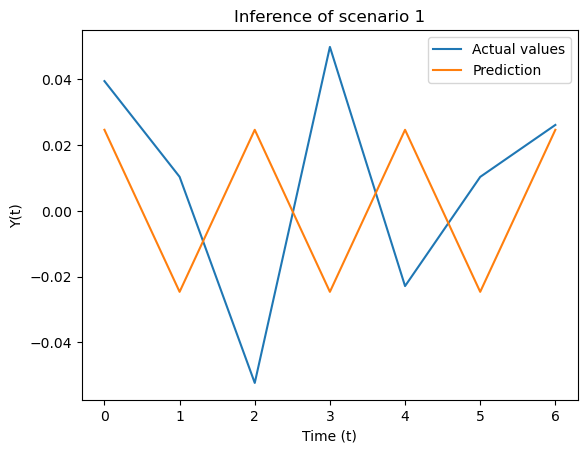

In [132]:
"""# get sequences for comparison
whole_seq = df_stationary.loc[]
all_pred_seq = np.array(pred_seq) 
mae = np.mean(np.abs(whole_seq - all_pred_seq))
print("MAE: ", round(mae, 2))"""

# get curves on a sampe plot
plt.plot(np.arange(length), actual_seq, label="Actual values")
plt.plot(np.arange(length), pred_seq, label="Prediction")

plt.title("Inference of scenario 1")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()